In [1]:
import random
import re
import codecs
import struct
import pprint
import collections

In [2]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import matplotlib.pyplot as plt

In [3]:
import torch
import torchtext

In [4]:
df = pd.read_csv("train.csv")

In [5]:
df.sample(n=3)

,id,keyword,location,text,target
2326,3342,demolished,"Catalonia, Spain",Demolished My Personal Best http://t.co/ImULL...,0
6171,8801,sirens,"Nomad, USA",Fuck Sleeping With Sirens.,0
7226,10348,weapons,NaN,I liked a @YouTube video from @dannyonpc http:...,0


# Preprocess

The data appears messy...

In [6]:
for t in df.loc[df.text.str.contains("\x89")].sample(3).itertuples():
    i = t.text.index("\x89")
    print("[...]", bytes(t.text, encoding="utf8")[i-16:i+16], "[...]")
    print()

[...] b' old city of San\xc2\x89\xc3\x9b\xc2\xaaa followin' [...]

[...] b'bloody cleav... \xc2\x89\xc3\x9b\xc3\x93 Eh hello!' [...]

[...] b'maturu -Over 600\xc2\x89\xc3\x9b_ http://t.c' [...]



In [7]:
def bad_byte(b):
    return "\\x" in str(b)

def find_bad_bytes_seqs(bs):
    ongoing = []
    bad_bytes = []
    for b in struct.unpack(f"{len(bs)}c", bs):
        if bad_byte(b):
            ongoing.append(ord(b))
        else:
            if ongoing:
                bad_bytes.append(bytes(ongoing))
                ongoing = []
    return bad_bytes

In [8]:
badies = []
with open("train.csv", "rb") as f:
    for line in f:
        badies.extend(find_bad_bytes_seqs(line))
counter_bad = collections.Counter(badies)
pprint.pprint(counter_bad)

Counter({b'\xc2\x89\xc3\x9b': 355,
         b'\xc2\x89\xc3\x9b\xc2\xaa': 191,
         b'\xc2\x89\xc3\x9b\xc3\x8f': 69,
         b'\xc3\xa5\xc3\x8a': 58,
         b'\xc2\x89\xc3\x9b\xc3\xb7': 49,
         b'\xc2\x89\xc3\x9b\xc2\x9d': 44,
         b'\xc2\x89\xc3\x9b\xc3\x92': 43,
         b'\xc2\x89\xc3\x9b\xc3\x93': 34,
         b'\xc2\x89\xc3\x9b\xc2\xa2': 34,
         b'\xc3\x8c\xc3\x8f': 20,
         b'\xc3\x8c': 17,
         b'\xc3\x8c\xc2\xa9': 17,
         b'\xc3\xa5\xc2\xa1': 12,
         b'\xc3\x8c\xc2\xa3': 10,
         b'\xc3\xa5\xc2\xa3': 6,
         b'\xc3\xa5': 6,
         b'\xc3\x8c\xc2\xbc': 6,
         b'\xc3\xa5\xc3\x88': 6,
         b'\xc3\xa5\xc2\xa8': 6,
         b'\xc3\x8c\xc3\x81': 6,
         b'\xc2\x89\xc3\xa3\xc2\xa2': 5,
         b'\xc3\x8c\xc2\xb1': 5,
         b'\xc3\xa5\xc3\xa1': 5,
         b'\xc3\x8c\xc3\x91': 4,
         b'\xc3\x8c\xc3\xbc': 3,
         b'\xc3\xa5\xc3\x87': 3,
         b'\xc3\x8c\xc2\xac': 2,
         b'\xc3\x8c\xc2\xa2': 2,
         b'\

In [9]:
subb = b"\xc2\x89\xc3\x9b\xc3\x92\xc3\xa5\xc3\x8a"
for t in df.text:
    t_bytes = bytes(t, "utf8")
    idx = t_bytes.find(subb)
    if idx > -1:
        print(t_bytes[idx-16: idx + len(subb) + 16])

b'ey\xc2\x89\xc3\x9b\xc2\xaas stock \xc2\x89\xc3\x9b\xc3\x92\xc3\xa5\xc3\x8aCNBC http://t.co'


for now, let's remove those chars

In [10]:
ordered_badies = sorted(counter_bad, key=len, reverse=True)

In [11]:
def rm_badies(s):
    s_bytes = bytes(s, "utf8")
    for badie in ordered_badies:
        while(badie in s_bytes):
            s_bytes = s_bytes.replace(badie, b" ")
    return s_bytes.decode("utf8")

In [12]:
rm_badies(b'ey\xc2\x89\xc3\x9b\xc2\xaas stock \xc2\x89\xc3\x9b\xc3\x92\xc3\xa5\xc3\x8aCNBC http://t.co'.decode("utf8"))

'ey s stock  CNBC http://t.co'

In [13]:
df_text_cleaned = df.text.apply(rm_badies)
diffs = df_text_cleaned != df.text

In [14]:
for old, new in random.sample(list(zip(df.text[diffs], df_text_cleaned[diffs])), 5):
    print(old)
    print(new)
    print()

I Will Survive by Gloria Gaynor (with Oktaviana Devi) ÛÓ https://t.co/HUkJZ1wT36
I Will Survive by Gloria Gaynor (with Oktaviana Devi)   https://t.co/HUkJZ1wT36

New Ladies Shoulder Tote Handbag Faux Leather Hobo Purse Cross Body Bag Womens - Full readÛ_ http://t.co/4FXfllRIen http://t.co/i12NLSr8Fk
New Ladies Shoulder Tote Handbag Faux Leather Hobo Purse Cross Body Bag Womens - Full read _ http://t.co/4FXfllRIen http://t.co/i12NLSr8Fk

2pcs 18W CREE Led Work Light  Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full reaÛ_ http://t.co/VDeFmulx43 http://t.co/yqpAIjSa5g
2pcs 18W CREE Led Work Light  Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full rea _ http://t.co/VDeFmulx43 http://t.co/yqpAIjSa5g

Rly tragedy in MP: Some live to recount horror: ÛÏWhen I saw coaches of my train plunging into water I called ... http://t.co/ZkgQSpwYj3
Rly tragedy in MP: Some live to recount horror:  When I saw coaches of my train plunging into water I called ... http://t.co/ZkgQSpwYj3

Re

In [15]:
df.text = df_text_cleaned

In [16]:
df.to_csv("train_preprocessed.csv", index=False, encoding="utf8")

# Load

In [17]:
DEVICE = torch.device("cuda")

In [18]:
tokenizer = nltk.tokenize.TweetTokenizer()

In [19]:
def _replace(word):
    if word.startswith("http"):
        return "<LINK>"
    if word.startswith("@"):
        return "<@>"
    if word.startswith("#"):
        return "<#>"
    return word


def tokenize(sentence):
    tokens = tokenizer.tokenize(sentence)
    return list(map(_replace, tokens))

In [20]:
for t in df.sample(5).itertuples():
    print(t.target, ":", t.text)
    print(tokenize(t.text))

0 : God the @mets are so cocky right now and I love it. Uribe OBLITERATED that ball then strutted the fuck out of the batters box...
['God', 'the', '<@>', 'are', 'so', 'cocky', 'right', 'now', 'and', 'I', 'love', 'it', '.', 'Uribe', 'OBLITERATED', 'that', 'ball', 'then', 'strutted', 'the', 'fuck', 'out', 'of', 'the', 'batters', 'box', '...']
0 : Dr. Jim &amp; the tsunami: The latest New Yorker warned us in no uncertain terms. Haven't you heard? The tsunami's... http://t.co/1RrEO2jG9u
['Dr', '.', 'Jim', '&', 'the', 'tsunami', ':', 'The', 'latest', 'New', 'Yorker', 'warned', 'us', 'in', 'no', 'uncertain', 'terms', '.', "Haven't", 'you', 'heard', '?', 'The', "tsunami's", '...', '<LINK>']
0 : [News Update] | Enugu Government to demolish illegal structures at International Conference Centre http://t.co/xcGzc45gys |Via Daily Post
['[', 'News', 'Update', ']', '|', 'Enugu', 'Government', 'to', 'demolish', 'illegal', 'structures', 'at', 'International', 'Conference', 'Centre', '<LINK>', '|', 'V

In [21]:
TEXT = torchtext.data.Field(tokenize = tokenize,
                            include_lengths=True)
TARGET = torchtext.data.LabelField(dtype=torch.float)

In [22]:
dataset = torchtext.data.TabularDataset("train_preprocessed.csv",
                                        format="csv",
                                        fields={"text": ("input", TEXT), "target": ("target", TARGET)})

In [23]:
data_train, data_valid = dataset.split(split_ratio=0.8)

In [162]:
def generate_examples_from(example):
    forgettables = ["<LINK>", "<#>"]
    _input, _target = example.input, example.target
    close = []
    for idx, elt in enumerate(_input):
        if elt in forgettables:
            close.append(_input[:idx] + _input[idx+1:])
    return [torchtext.data.example.Example.fromlist(data=[inp, _target],
                                                    fields=[("input", TEXT), ("target", TARGET)])
            for inp in close]

In [165]:
generated_examples = []
for example in data_train:
    generated_examples.extend(generate_close_examples(example))

In [169]:
data_train.examples.extend(generated_examples)

In [170]:
VOCAB_MAX_SIZE = 20000
TEXT.build_vocab(data_train, max_size=VOCAB_MAX_SIZE, vectors="glove.twitter.27B.100d")

In [171]:
TARGET.build_vocab(data_train)
TARGET.vocab.stoi

defaultdict(None, {'0': 0, '1': 1})

In [172]:
BATCH_SIZE = 256
iter_train, iter_valid = \
    torchtext.data.BucketIterator.splits(datasets=(data_train, data_valid),
                                         batch_size=BATCH_SIZE,
                                         device=DEVICE,
                                         sort_within_batch=True,
                                         sort_key=lambda example: len(example.input),
                                         sort=False)

# Model

In [27]:
class RNN(torch.nn.Module):
    def __init__(self, n_vocab, embedding_dim, hidden_dim, output_dim, dropout, bidirectional,
                 n_layers, pad_idx):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.bidirectional = bidirectional
        num_dir = 2 if bidirectional else 1
        self.embedding = torch.nn.Embedding(n_vocab, embedding_dim, padding_idx=pad_idx)
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim,
                                 bidirectional=bidirectional,
                                 num_layers=n_layers,
                                 dropout=dropout)
        self.fc = torch.nn.Linear(hidden_dim * num_dir, output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_lengths):
        input, lengths = input_lengths
        torch.nn.utils.rnn.pack_padded_sequence(input, lengths)
        embedded = self.embedding(input)  # ((sent_len, batch), emb_dim)
        packed_output, (hidden, cell) = self.rnn(embedded)  # hidden: (num_layers * num_directions,
                                                            #          batch, hidden_size * num_directions)
        hidden = (torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)
                  if self.bidirectional else hidden[-1, :, :]).squeeze(0)  # (batch, hidden_size * num_directions)
        return self.sigmoid(self.fc(self.dropout(hidden)))  # (batch, 1)

In [28]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
N_VOCAB = len(TEXT.vocab)

In [29]:
N_VOCAB

15996

In [30]:
DEFAULT_PARAMS = {
    "n_vocab": N_VOCAB,
    "embedding_dim": 100,
    "hidden_dim": 256,
    "output_dim": 1,
    "dropout": 0.5,
    "bidirectional": True,
    "n_layers": 2,
    "pad_idx": PAD_IDX,
}

def default_model(**kwargs):
    _d = {}
    _d.update(DEFAULT_PARAMS)
    _d.update(kwargs)
    return RNN(**_d)

In [31]:
def pseudo_init(model, criterion, device=DEVICE, learn_embedding_param=True):
    model.embedding.weight.data.copy_(TEXT.vocab.vectors)
    model.embedding.weight.data[UNK_IDX] = torch.zeros(model.embedding_dim)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(model.embedding_dim)
    
    for name, param in model.named_parameters():
        if name == "embedding.weight":
            param.requires_grad = learn_embedding_param
    
    print("The model has {:,} trainable parameters"
         .format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    return model, criterion

In [32]:
def output_to_pred(output):
    return torch.round(output)


def accuracy(output, trues):
    results = (output_to_pred(output) == trues).float()
    return (results.sum() / len(results))


def f1_score(preds, trues):
    return sklearn.metrics.f1_score(trues, preds)

def output_f1_score(output, trues):
    return sklearn.metrics.f1_score(trues.cpu().detach().numpy(), output_to_pred(output).cpu().detach().numpy())

# Train

In [33]:
from nntraining.pytorch.supervised import do_training, Measurer, is_max_of

In [34]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path, device=DEVICE):
    model.load_state_dict(torch.load(path))
    model.to(device)
    return model

In [35]:
class SingleAvgMeasurer(Measurer):
    def __init__(self, fun_measure, measure_name):
        super().__init__()
        self.fun_measure = fun_measure
        self.measure_name = measure_name
        self.sum_measures = 0
        self._count = 0
        
    def update(self, batch, get_input, get_target, batch_output, batch_loss):
        self.sum_measures += self.fun_measure(batch_output, get_target(batch))
        self._count += 1
    
    def to_dict(self):
        return {self.measure_name: self.sum_measures / self._count}

def print_status(epoch, n_epochs, train_measures, valid_measures, is_best, duration):
    print("Epoch: {e:.<{max_len}}. T, V f1: {train:.1f}, {valid:.1f}. Took {t:.2f}s.{best}"
          .format(e=epoch + 1,
                  max_len=len(str(n_epochs)),
                  train=100 * train_measures["f1 score"],
                  valid=100 * valid_measures["f1 score"],
                  t=duration,
                  best=" (+)" if is_best else ""))

In [184]:
model = default_model(hidden_dim=128, dropout=0.7)

In [185]:
model, criterion = pseudo_init(model, torch.nn.MSELoss())

The model has 2,230,641 trainable parameters


In [186]:
optimizer = torch.optim.Adam(model.parameters())

In [187]:
training_info = do_training(model=model,
                            name="first",
                            iter_train=iter_train,
                            iter_valid=iter_valid,
                            optimizer=optimizer,
                            criterion=criterion,
                            n_epochs=50,
                            measurer_getter=SingleAvgMeasurer.getter(fun_measure=output_f1_score,
                                                                     measure_name="f1 score"),
                            fun_save=lambda model: save_model(model, "model.pt"),
                            fun_is_best=is_max_of("f1 score"),
                            fun_print_status=print_status 
                           )

Starting training: 50 epochs.
Epoch: 1.. T, V f1: 54.6, 60.1. Took 0.92s. (+)
Epoch: 2.. T, V f1: 79.0, 60.7. Took 0.90s. (+)
Epoch: 3.. T, V f1: 86.2, 65.4. Took 0.90s. (+)
Epoch: 4.. T, V f1: 90.6, 59.3. Took 0.90s.
Epoch: 5.. T, V f1: 92.6, 61.0. Took 0.89s.
Epoch: 6.. T, V f1: 92.2, 70.1. Took 0.88s. (+)
Epoch: 7.. T, V f1: 94.9, 57.4. Took 0.89s.
Epoch: 8.. T, V f1: 95.6, 53.7. Took 0.90s.
Epoch: 9.. T, V f1: 96.3, 65.8. Took 0.91s.
Epoch: 10. T, V f1: 96.5, 53.7. Took 0.85s.
Epoch: 11. T, V f1: 97.1, 57.1. Took 0.87s.
Epoch: 12. T, V f1: 97.1, 64.5. Took 0.87s.
Epoch: 13. T, V f1: 97.2, 67.1. Took 0.88s.
Epoch: 14. T, V f1: 97.2, 64.1. Took 0.87s.
Epoch: 15. T, V f1: 97.4, 66.7. Took 0.86s.
Epoch: 16. T, V f1: 97.5, 62.2. Took 0.88s.
Epoch: 17. T, V f1: 97.4, 61.8. Took 0.88s.
Epoch: 18. T, V f1: 97.5, 67.9. Took 0.88s.
Epoch: 19. T, V f1: 96.9, 68.2. Took 0.88s.
Epoch: 20. T, V f1: 97.5, 57.5. Took 0.91s.
Epoch: 21. T, V f1: 97.6, 57.7. Took 0.88s.
Epoch: 22. T, V f1: 97.5, 66.3

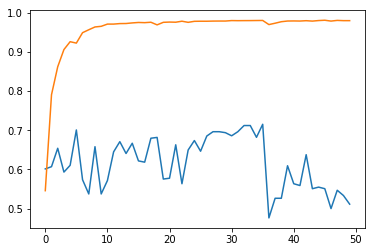

In [189]:
fig, ax = plt.subplots()
ax.plot(list(range(len(training_info.valid["f1 score"]))), training_info.valid["f1 score"], label="valid")
ax.plot(list(range(len(training_info.train["f1 score"]))), training_info.train["f1 score"], label="train")
plt.show()

# Predict

In [41]:
model_king = load_model(model, "model.pt")

In [42]:
from nntraining.pytorch.text import Predictor

In [43]:
predictor = Predictor(model, TEXT.vocab.stoi, tokenize)

In [44]:
df_test = pd.read_csv("test.csv").set_index("id")

In [45]:
df_test.sample(3)

,keyword,location,text
id,,,
5718,forest%20fire,"Oregon, USA",Grass fire near Forest Grove contained. Sparke...
10095,typhoon,NaN,#WorldNews #World\n Saipan Has No Water Electr...
2705,crushed,"Lawn, PA",So my Neptunia girls are all nearly level 150 ...


In [46]:
df_test["target"] = df_test.text.apply(lambda sentence: int(np.round(predictor.predict(rm_badies(sentence)))))

In [47]:
df_test.sample(3)

,keyword,location,text,target
id,,,,
827,battle,Australia,#LonePine remembered around Australia as 'desc...,0
1785,buildings%20on%20fire,Fallen TX,It's a testimony to the human spirit that more...,1
8492,screaming,NaN,@camilacabello97 screaming internally and exte...,0


In [48]:
df_test[["target"]].to_csv("submission.csv")